## Exercise 1: Logistic Regression on a Toy 2D Dataset

1. Generate two Gaussian clusters in $\mathbb{R}^2$ and associate them with a class depending on which cluster each point lies on, e.g.:
   - Class 0 centered at $(-2, -2)$ with variance $1$,
   - Class 1 centered at $(2, 2)$ with variance $0.5$.



In [19]:
import numpy as np
import matplotlib.pyplot as plt
np.seterr(all="ignore")

n0 = 1000
n1 = 1000

mu0 = np.array([-2, -2])
mu1 = np.array([2, 2])

sigma0 = 1 * np.eye(2)
sigma1 = 0.5 * np.eye(2)

X0 = np.random.multivariate_normal(mu0, sigma0, n0)
X1 = np.random.multivariate_normal(mu1, sigma1, n1)

y0 = np.zeros(n0)
y1 = np.ones(n1)

X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])

N = X.shape[0]

2. Plot the dataset in 2D using `plt.scatter` so that each cluster is colored according to its class.

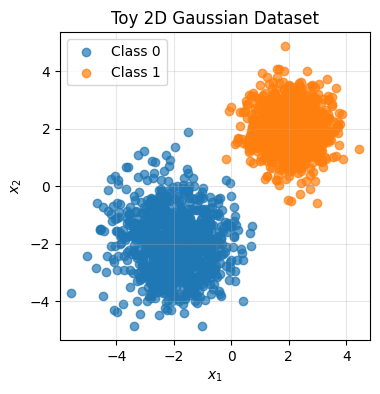

In [20]:
plt.figure(figsize=(4, 4))

plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color="tab:blue", alpha=0.7, label="Class 0")

plt.scatter(X[y == 1, 0], X[y == 1, 1],
            color="tab:orange", alpha=0.7, label="Class 1")

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Toy 2D Gaussian Dataset")
plt.legend()
plt.grid(alpha=0.3)
plt.axis("equal")

plt.show()


3. Implement logistic regression **from scratch** as did during class:
   
   $$
   f_\Theta(x) = \sigma(\Theta^T x),
   \qquad 
   \ell(\Theta; x,y)= -\big[y\log f_\Theta(x) + (1-y)\log(1 - f_\Theta(x))\big].
   $$

In [21]:
def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def model(Theta, X):
    return sigmoid(X @ Theta)

def l(Theta, X, Y):
    Y_hat = model(Theta, X)
    eps = 1e-12
    Y_hat = np.clip(Y_hat, eps, 1 - eps)
    return -np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

def grad_l(Theta, X, Y):
    N = X.shape[0]
    Y_hat = model(Theta, X)
    return (X.T @ (Y_hat - Y)) / N


4. Train it using simple Gradient Descent on the full dataset. **Note:** the computation of $\nabla \mathcal{L}(\Theta; X, Y)$ for this choice of $\ell$ is given in the teaching note.


In [22]:
def GD(l, grad_l, Theta0, X, Y, eta, maxit):
    Theta = Theta0.copy()
    Theta_vals = [Theta.copy()]
    losses = [l(Theta, X, Y)]

    for k in range(maxit):
        Theta = Theta - eta * grad_l(Theta, X, Y)
        Theta_vals.append(Theta.copy())
        losses.append(l(Theta, X, Y))

    return Theta, np.array(Theta_vals), np.array(losses)

X_aug = np.hstack([np.ones((X.shape[0], 1)), X])  
Y = y.reshape(-1, 1)                                

eta = 0.1
maxit = 1000
Theta0 = np.zeros((X_aug.shape[1], 1))              

Theta_star, Theta_hist, loss_hist = GD(
    l, grad_l,
    Theta0,
    X_aug, Y,
    eta=eta,
    maxit=maxit
)


5. Visualize the learned **decision boundary**:
   - plot the line $\{\Theta^T x = 0\}$,
   - overlay with the dataset.


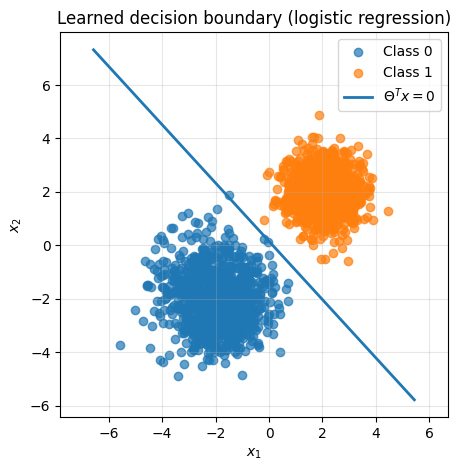

In [23]:
b, w1, w2 = Theta_star.ravel()

plt.figure(figsize=(5, 5))

plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.7, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.7, label="Class 1")

x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_line = np.linspace(x1_min, x1_max, 200)

if abs(w2) > 1e-12:
    x2_line = -(b + w1 * x1_line) / w2
    plt.plot(x1_line, x2_line, linewidth=2, label=r"$\Theta^T x = 0$")
else:
    x1_boundary = -b / w1
    plt.axvline(x1_boundary, linewidth=2, label=r"$\Theta^T x = 0$")

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Learned decision boundary (logistic regression)")
plt.grid(alpha=0.3)
plt.axis("equal")
plt.legend()
plt.show()


6. Comment on why the decision boundary is linear.

## Exercise 2: SGD on Logistic Regression

Use the same synthetic dataset used in the previous exercise, but train logistic regression using **SGD** with the following choices:

1. Try different batch sizes:
   - $N_{\text{batch}} = 1$,
   - $N_{\text{batch}} = 10$,
   - $N_{\text{batch}} = N$ (full GD).

In [24]:
def accuracy(Theta, X, Y):
    p = model(Theta, X)
    y_pred = (p >= 0.5).astype(int)
    return np.mean(y_pred == Y)


def SGD(l, grad_l, X, Y, Theta0, lr=1e-2, batch_size=32, epochs=10):
    Theta = Theta0.copy()

    loss_hist = []
    acc_hist = []

    N = X.shape[0]

    for epoch in range(epochs):
        idx = np.random.permutation(N)
        Xs, Ys = X[idx], Y[idx]

        for start in range(0, N, batch_size):
            Xb = Xs[start:start+batch_size]
            Yb = Ys[start:start+batch_size]

            g = grad_l(Theta, Xb, Yb)
            Theta = Theta - lr * g

        loss_hist.append(l(Theta, X, Y))
        acc_hist.append(accuracy(Theta, X, Y))

    return Theta, np.array(loss_hist), np.array(acc_hist)

X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
Y = y.reshape(-1, 1)

N = X_aug.shape[0]
batch_sizes = [1, 10, N]

lr = 0.1
epochs = 100
Theta0 = np.zeros((X_aug.shape[1], 1))

results = {}

for B in batch_sizes:
    Theta_star, loss_hist, acc_hist = SGD(
        l, grad_l,
        X_aug, Y,
        Theta0,
        lr=lr,
        batch_size=B,
        epochs=epochs
    )
    results[B] = {
        "Theta": Theta_star,
        "loss": loss_hist,
        "acc": acc_hist
    }
    print(f"B={B}: final loss={loss_hist[-1]:.4f}, final acc={acc_hist[-1]:.3f}")


B=1: final loss=0.0004, final acc=1.000
B=10: final loss=0.0010, final acc=1.000
B=2000: final loss=0.0260, final acc=0.999


2. For each setting:
   - Plot the loss vs epoch,
   - Plot the classification accuracy vs epoch.

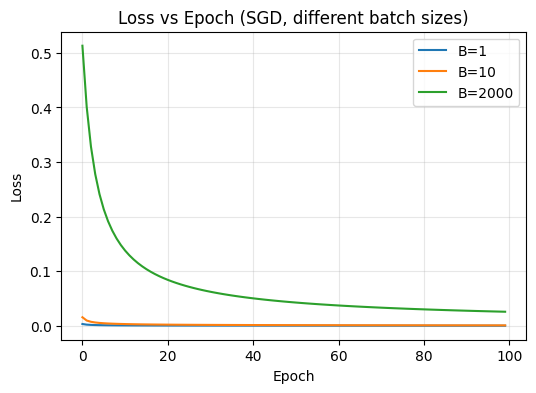

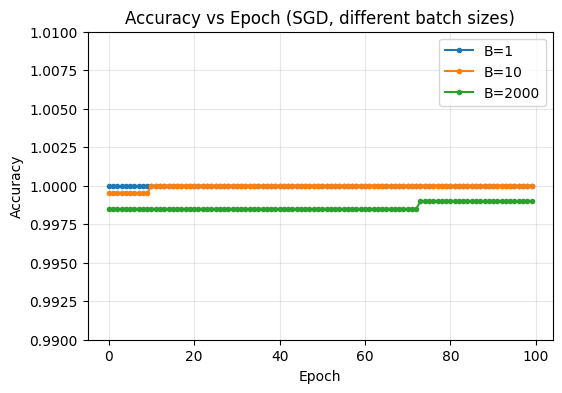

In [25]:
plt.figure(figsize=(6,4))
for B in batch_sizes:
    plt.plot(results[B]["loss"], label=f"B={B}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch (SGD, different batch sizes)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
for B in batch_sizes:
    plt.plot(results[B]["acc"], marker="o", markersize=3, label=f"B={B}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch (SGD, different batch sizes)")
plt.grid(alpha=0.3)
plt.legend()
plt.ylim(0.99, 1.01)   
plt.show()



3. Compare the stability and speed of convergence over the choice of different batch sizes.

4. Why the gradients become noisier for small batches? Why larger batches give smoother curves?

## Exercise 3: Evaluation Metrics on a Synthetic Dataset

Using the logistic regression model trained above:

1. Compute predicted probabilities $\hat y_i = f_\Theta(x_i)$.

In [26]:
probs = model(Theta_star, X_aug).ravel()

2. Convert them to binary predictions $\hat y_i \in \{0,1\}$ using threshold $0.5$.

In [27]:
def predict_labels(probs, threshold=0.5):
    return (probs >= threshold).astype(int)
y_pred = {}
y_pred[0.5] = predict_labels(probs, threshold=0.5)

3. Compute:
   - Confusion matrix (TP, FP, FN, TN),
   - Accuracy,
   - Precision,
   - Recall,
   - F1-score.

In [28]:
def confusion_matrix_metrics(y_true, y_pred):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    TP = np.sum((y_true==1) & (y_pred==1))
    TN = np.sum((y_true==0) & (y_pred==0))
    FP = np.sum((y_true==0) & (y_pred==1))
    FN = np.sum((y_true==1) & (y_pred==0))

    acc = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return (TP, FP, FN, TN),{ "accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1}

conf_matrix, metrics = {} , {}
conf_matrix[0.5], metrics[0.5] = confusion_matrix_metrics(Y, y_pred[0.5])

4. Modify the threshold to:
   - $0.3$,
   - $0.7$,
   and repeat.

In [29]:
thresholds = [0.3, 0.5, 0.7]
y_pred[0.3] = predict_labels(probs, threshold=0.3)
y_pred[0.7] = predict_labels(probs, threshold=0.7)
conf_matrix[0.3], metrics[0.3] = confusion_matrix_metrics(Y, y_pred[0.3])
conf_matrix[0.7], metrics[0.7] = confusion_matrix_metrics(Y, y_pred[0.7])

for t in thresholds:
    print(f"\n--- Threshold = {t} ---")
    print(f"Confusion matrix counts: TP={conf_matrix[t][0]}, FP={conf_matrix[t][1]}, FN={conf_matrix[t][2]}, TN={conf_matrix[t][3]}")
    print(f"Accuracy : {metrics[t]['accuracy']:.4f}")
    print(f"Precision: {metrics[t]['precision']:.4f}")
    print(f"Recall   : {metrics[t]['recall']:.4f}")
    print(f"F1-score : {metrics[t]['f1_score']:.4f}")


--- Threshold = 0.3 ---
Confusion matrix counts: TP=1000, FP=7, FN=0, TN=993
Accuracy : 0.9965
Precision: 0.9930
Recall   : 1.0000
F1-score : 0.9965

--- Threshold = 0.5 ---
Confusion matrix counts: TP=1000, FP=2, FN=0, TN=998
Accuracy : 0.9990
Precision: 0.9980
Recall   : 1.0000
F1-score : 0.9990

--- Threshold = 0.7 ---
Confusion matrix counts: TP=999, FP=0, FN=1, TN=1000
Accuracy : 0.9995
Precision: 1.0000
Recall   : 0.9990
F1-score : 0.9995


5. Comment on:
   - How lower thresholds increase recall and lower precision,
   - How higher thresholds increase precision and reduce recall,
   - Why classification metrics depend on the application (as discussed in class).


## Exercise 4: Logistic Regression on a Real Dataset

Reproduce the pipeline from the book using the **Pima Indians Diabetes Dataset**, available at https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.

This dataset contains medical measurements and a binary label indicating diabetes diagnosis.

1. Preprocess the data as done in class:
   - Download `diabetes.csv`.
   - Extract features $X$ and labels $y$.
   - **Standardize the features** (mean 0, variance 1).  
      Explain why normalization is required, connecting to:
      - conditioning,
      - stable optimization,
      - meaningful gradient magnitudes.

   - Add a bias column of 1s.

In [30]:
import pandas as pd

data = pd.read_csv("../data/diabetes.csv")
X = data.drop("Outcome", axis=1).values
y = data["Outcome"].values.reshape(-1, 1)

X = (X - X.mean(axis=0))/ X.std(axis=0)

X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
N, d = X_aug.shape

2. Implement logistic regression from scratch (sigmoid + BCE + gradient), and optimize using **SGD** with: 
   - a batch size of 32, a learning rate of $10^{-3}$, and 200 epochs.
   - for each epoch, track full-dataset BCE loss and full-dataset accuracy.
   - in a plot, visualize the behavior of Loss vs epoch and Accuracy vs epoch. Comment the results.


In [31]:
def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def model(Theta, X):
    return sigmoid(X @ Theta)

def logistic_loss(Theta, X, Y):
    Y_hat = model(Theta, X)
    eps = 1e-12
    Y_hat = np.clip(Y_hat, eps, 1 - eps)  
    return -np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

def grad_logistic_loss(Theta, X, Y):
    N = X.shape[0]
    Y_hat = model(Theta, X)
    return (1.0 / N) * (X.T @ (Y_hat - Y))

def accuracy_from_probs(p, Y, threshold=0.5):
    y_pred = (p >= threshold).astype(int)
    return np.mean(y_pred == Y)

def accuracy(Theta, X, Y, threshold=0.5):
    p = model(Theta, X)
    return accuracy_from_probs(p, Y, threshold)


def SGD(l, grad_l, X, Y, Theta0, lr=1e-3, batch_size=32, epochs=200, seed=0):
    rng = np.random.default_rng(seed)
    Theta = Theta0.copy()

    N = X.shape[0]
    loss_hist = []
    acc_hist = []

    for epoch in range(epochs):
        idx = rng.permutation(N)

        for start in range(0, N, batch_size):
            batch_idx = idx[start:start+batch_size]
            Xb, Yb = X[batch_idx], Y[batch_idx]
            g = grad_l(Theta, Xb, Yb)
            Theta = Theta - lr * g

        loss_hist.append(l(Theta, X, Y))
        acc_hist.append(accuracy(Theta, X, Y))

    return Theta, loss_hist, acc_hist



3. Train the same model using **Adam** (using the formulas from class):
   
   $$
   \Theta_{k+1} = \Theta_k - \eta \frac{\hat m_k}{\sqrt{\hat v_k} + \epsilon}.
   $$

   with a learning rate of $10^{-3}$, a batch size of 32, and 200 epochs. Then, plot SGD vs Adam loss and accuracy curves.

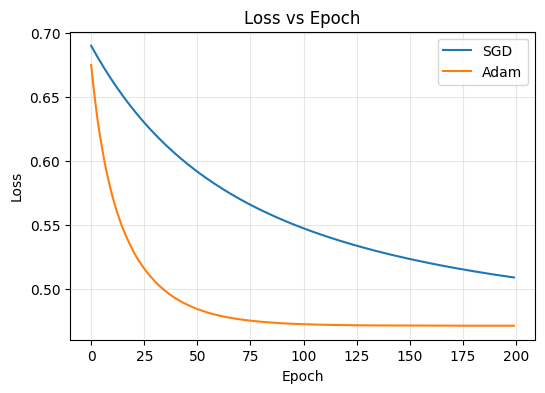

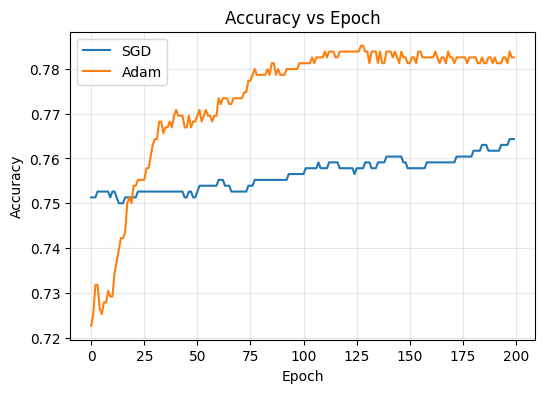

In [32]:
def Adam(l, grad_l, X, Y, Theta0, lr=1e-3, batch_size=32, epochs=200,
         beta1=0.9, beta2=0.999, eps=1e-8, seed=0):

    rng = np.random.default_rng(seed)
    Theta = Theta0.copy()

    m = np.zeros_like(Theta)
    v = np.zeros_like(Theta)
    t = 0

    N = X.shape[0]
    loss_hist = []
    acc_hist = []

    for epoch in range(epochs):
        idx = rng.permutation(N)

        for start in range(0, N, batch_size):
            batch_idx = idx[start:start+batch_size]
            Xb, Yb = X[batch_idx], Y[batch_idx]

            g = grad_l(Theta, Xb, Yb)

            t += 1
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)

            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)

            Theta = Theta - lr * (m_hat / (np.sqrt(v_hat) + eps))

        loss_hist.append(l(Theta, X, Y))
        acc_hist.append(accuracy(Theta, X, Y))

    return Theta, loss_hist, acc_hist

Theta0 = np.zeros((X_aug.shape[1], 1))

batch_size = 32
lr = 1e-3
epochs = 200

Theta_sgd, loss_sgd, acc_sgd = SGD(
    logistic_loss, grad_logistic_loss,
    X_aug, y, Theta0,
    lr=lr, batch_size=batch_size, epochs=epochs, seed=0
)

Theta_adam, loss_adam, acc_adam = Adam(
    logistic_loss, grad_logistic_loss,
    X_aug, y, Theta0,
    lr=lr, batch_size=batch_size, epochs=epochs, seed=0
)

plt.figure(figsize=(6,4))
plt.plot(loss_sgd, label="SGD")
plt.plot(loss_adam, label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(acc_sgd, label="SGD")
plt.plot(acc_adam, label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


4. For each method, evaluate:
   - Final accuracy,
   - Confusion matrix,
   - Precision, Recall, F1.

In [33]:
def predict(Theta, X, threshold=0.5):
    return (model(Theta, X) >= threshold).astype(int)

def confusion_and_metrics(y_true, y_pred):
    y_true = y_true.astype(int).ravel()
    y_pred = y_pred.astype(int).ravel()

    TP = np.sum((y_true==1) & (y_pred==1))
    TN = np.sum((y_true==0) & (y_pred==0))
    FP = np.sum((y_true==0) & (y_pred==1))
    FN = np.sum((y_true==1) & (y_pred==0))

    acc = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall) > 0 else 0.0

    return {"TP":TP,"FP":FP,"FN":FN,"TN":TN,
            "accuracy":acc,"precision":precision,"recall":recall,"f1":f1}

for name, Theta in [("SGD", Theta_sgd), ("Adam", Theta_adam)]:
    y_pred = predict(Theta, X_aug, threshold=0.5)
    metrics = confusion_and_metrics(y, y_pred)
    print(f"\n=== {name} ===")
    print(f"Confusion: TP={metrics['TP']}, FP={metrics['FP']}, FN={metrics['FN']}, TN={metrics['TN']}")
    print(f"Accuracy : {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall   : {metrics['recall']:.4f}")
    print(f"F1       : {metrics['f1']:.4f}")



=== SGD ===
Confusion: TP=159, FP=72, FN=109, TN=428
Accuracy : 0.7643
Precision: 0.6883
Recall   : 0.5933
F1       : 0.6373

=== Adam ===
Confusion: TP=157, FP=56, FN=111, TN=444
Accuracy : 0.7826
Precision: 0.7371
Recall   : 0.5858
F1       : 0.6528


5. Discuss on which method converge faster, which oscillate more, and how this relates to adaptive learning rates discussed in class.
